I am looking for patterns suggesting that some proteins' expression levels correlate with genotype (control or Down Syndrom model) and/or learning.

In [51]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

In [2]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the mean per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/77 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
# data1 will all the protein level data in columns with the independent variables moved to the index
data1 = data.set_index(['Genotype','Behavior','Treatment'])
data1 = data1.drop(['class','Mouse'],axis = 1)

First, I am looking at a heatmap of the normalized expression data without clustering and with the individual mice arranged by group.  Many genes appear to show similar expression patterns to each other.

In [ ]:
# Set up y tick labels to mark divisions between groups
yticks = [0,10,19,29,38,47,54,63]
yticklabels = ['Control Learning Treated',
               'Control Learning Untreated',
               'Control NoLearning Treated',
               'Control NoLearning Untreated',
               'Downs Learning Treated',
               'Downs Learning Untreated',
               'Downs NoLearning Treated',
               'Downs NoLearning Untreated']

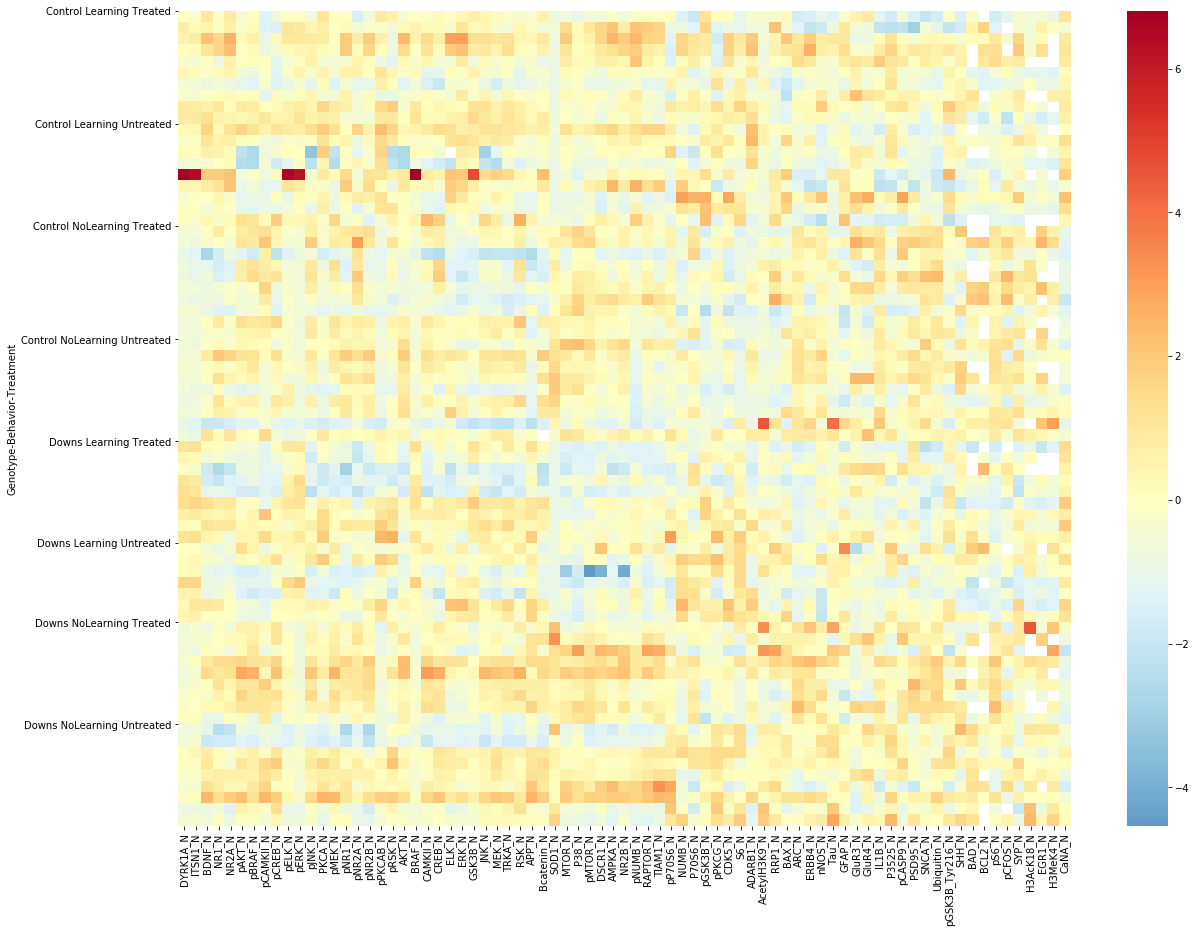

In [46]:
# Heatmap of normalized data - no clustering
# Data is normalized by z-scores ((x - mean)/std) so that all proteins are on approximately the same visual scale
# regardless of absolute expression levels
plt.figure(figsize=(20,15))
heat_ax = sns.heatmap((data1-data1.mean())/data1.std(),yticklabels=yticklabels,center=0,cmap='RdYlBu_r')
no_output = heat_ax.set_yticks(yticks)

Just by eye, it looks like the CaNA and SOD1 levels are related to whether the mouse experienced a learning paradigm.  Also DYRK1A and ITSN1.  I also notice an outlier mouse with some very high values for several proteins.

In [28]:
# Set up color code to use for all graphs
colors = [(0.3, 0.3,  1.0), (0.6, 0.6, 1.0), #Control genotype, Learning = dark blues; opaque = treated
          (0.3, 0.65, 1.0), (0.6, 0.8, 1.0), #Control genotype, No learning = light blues; opaque = treated
          (1.0, 0.3,  0.3), (1.0, 0.6, 0.6), #Down Syndrome, Learning = reds; opaque = treated
          (1.0, 0.65, 0.3), (1.0, 0.8, 0.6)] #Down Syndrome, No Learning = oranges; opaque = treated

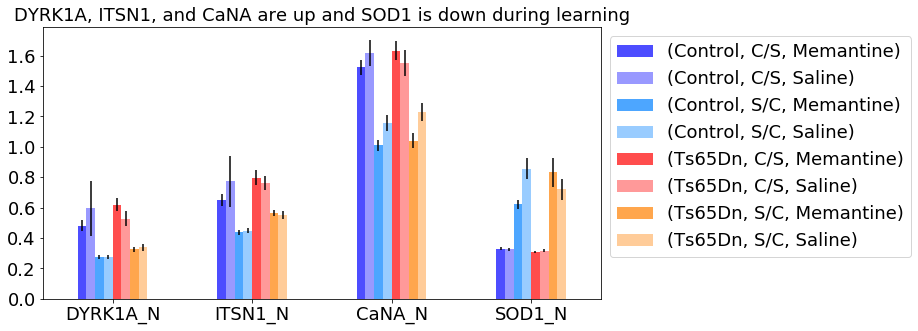

In [29]:
def selectedbargraph(column_names, **kwargs):
    # makes a bar graph with means and SEMs from each group of mice for the 
    # selected proteins of data1 using the colors previously set up.
    selection = data1.loc[:,column_names]
    means = selection.groupby(selection.index).mean().transpose()
    stds = selection.groupby(selection.index).std().transpose()
    counts = selection.groupby(selection.index).count().transpose()
    sems = stds / np.sqrt(counts)
    bar_ax = means.plot(kind = 'bar', yerr = sems, color = colors, **kwargs)
    return bar_ax

# Bar graph to see whether the mean levels of DYRK1A, ITSNI, CaNA, and SOD1 appear to be different with and without learning 
columns1 = ['DYRK1A_N','ITSN1_N','CaNA_N','SOD1_N']
bar_ax = selectedbargraph(columns1,figsize = (10,5), fontsize = 18, rot=0, 
                         title = 'DYRK1A, ITSN1, and CaNA are up and SOD1 is down during learning')
plt.legend(loc='upper left', bbox_to_anchor = [1,1], fontsize = 18)
bar_ax.title.set_fontsize(18)

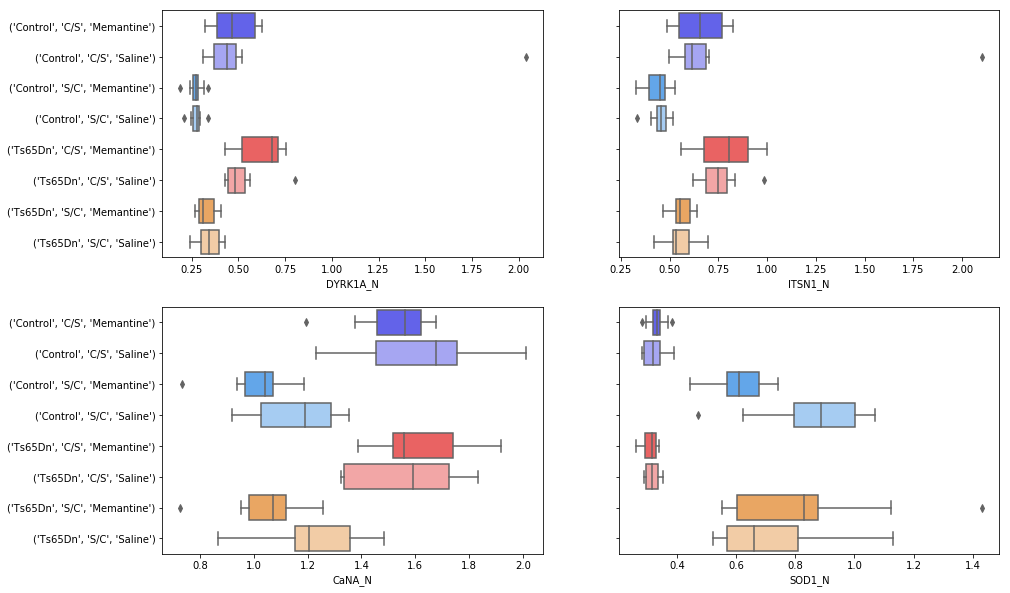

In [48]:
# Boxplots showing same data as bar graph above
plt.figure(figsize = (15,10))
plot_idx = 1
v_axes = []

for protein in columns1:
    plt.subplot(2,2,plot_idx)
    v_axes.append(sns.boxplot(y = data1.index, x = data1[protein], palette = colors, notch = False))
    if (plot_idx % 2) == 0:
        v_axes[plot_idx-1].set(yticklabels=[])
    plot_idx += 1

The same data as boxplots so as to better see the outliers.

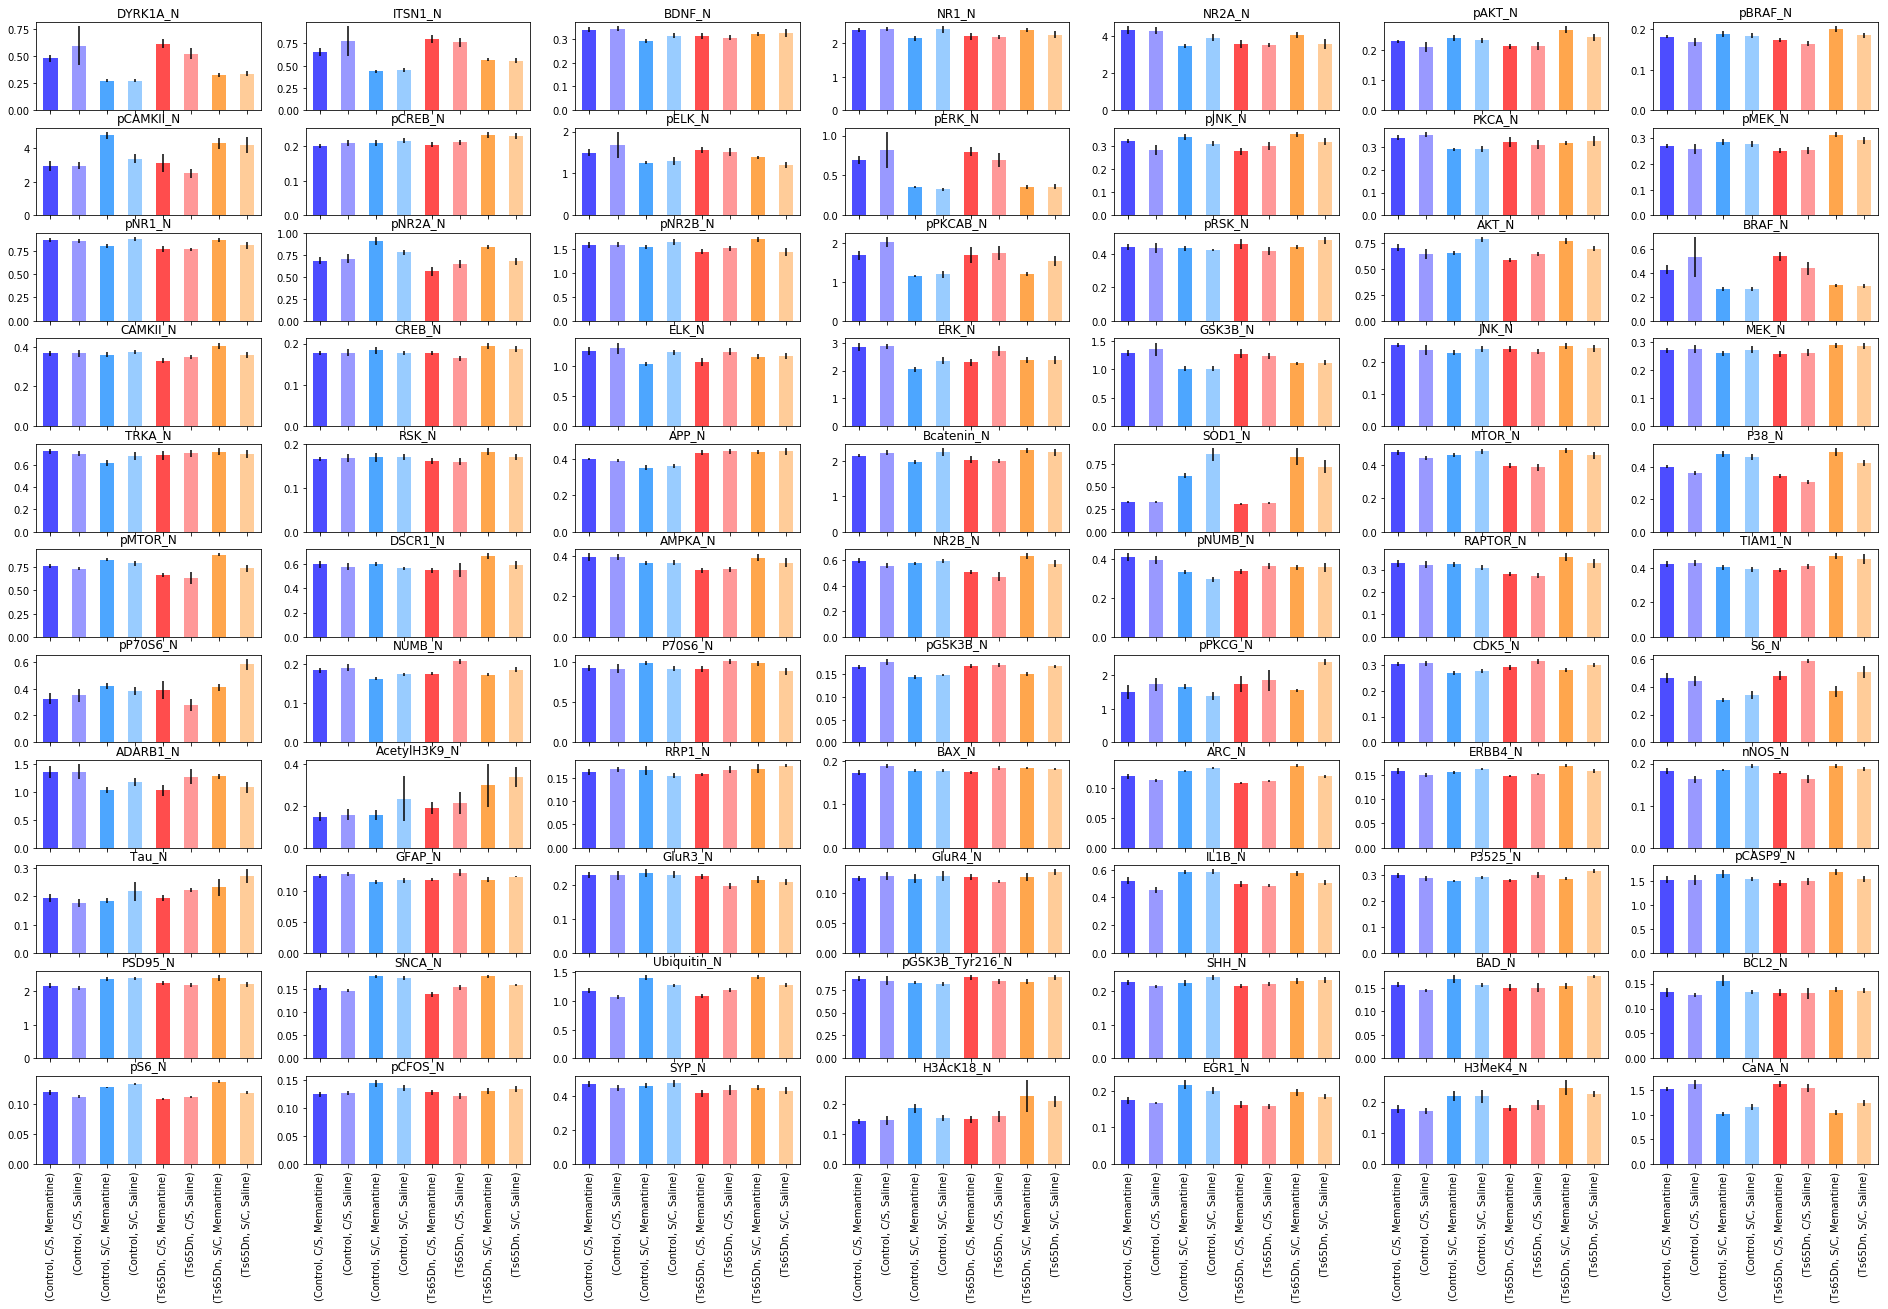

In [31]:
plot_idx = 1
bars_ax=[]
plt.figure(figsize=(33,21))
for protein in data1.columns:
    plt.subplot(11,7,plot_idx)
    bars_ax.append(selectedbargraph(protein, fontsize = 10, rot=90,title = protein, legend = False, sharex = True))
    plot_idx += 1

Here I am scanninng each protein to look for patterns in the mean levels that may associate with any of the grouping variables.

As bad as this visualization is, I think I can pull out a few more proteins whose levels correlate with learning: pERK, BRAF, GSK3B, pPKCAB, P38, pMTOR, PSD95, SNCA, Ubiquitin, H3MeK4, EGR1

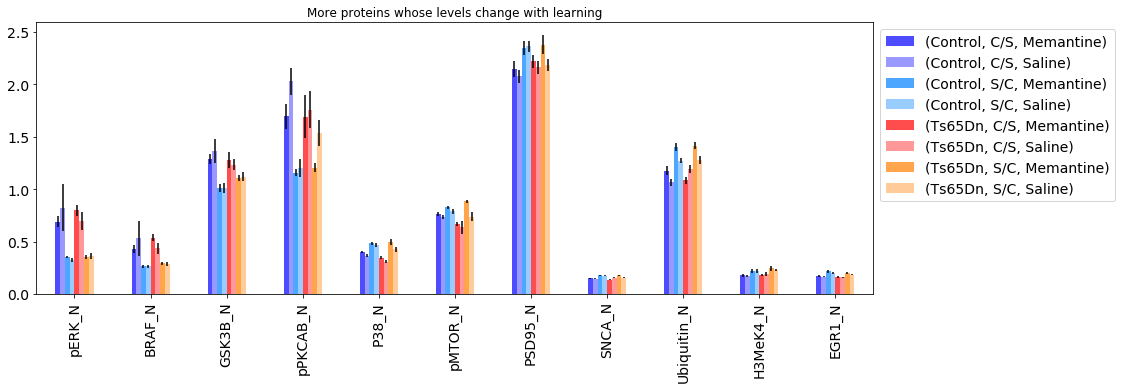

In [32]:
columns2 = ['pERK_N', 'BRAF_N', 'GSK3B_N', 'pPKCAB_N', 'P38_N', 'pMTOR_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'H3MeK4_N', 'EGR1_N']
bar_ax2 = selectedbargraph(columns2,figsize = (15,5), fontsize = 14, rot=90, 
                         title = 'More proteins whose levels change with learning')
plt.legend(loc='upper left', bbox_to_anchor = [1,1], fontsize = 14)
bar_ax.title.set_fontsize(18)

When looking globally at expression data, does the data cluster by group?  (Note that proteins with missing data had to be dropped from this analysis for now.)

In [33]:
# Apparently I can't use clustermap with missing values and I can't colorcode groups with a multiindex
# First, ignore proteins with missing values
data2 = data.loc[:,data.isnull().sum()==0]
# Then remove all non-protein variables, saving class for color-coding
groups = data2.pop('class')
data2 = data2.drop(['Genotype','Behavior','Treatment','Mouse'],axis=1)
# Create color code for row clustering
row_colors = groups.map(dict(zip(groups.unique(), colors)))

In [198]:
#Functions for squeezing a legend that defines the row colors onto a seaborn cluster map
def make_legend(colors,labels,axes = None):
    # makes a simple legend with colored patches and labels.  colors needs to be at least as long as labels.
    if axes is None:
        axes = plt.axes(frameon=False)
        axes.set_axis_off()
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(yticklabels))]
    leg = axes.legend(handles=patches)
    plt.show()
    return leg

def add_legend_to_cluster(clustermap):
    fig = clustermap.fig
    # First, shift all the existing axes in the clustermap left and up
    sf = [-0.1,0.1,1,1]
    for ax in fig.axes:
        pos = ax.get_position()
        ax.set_position([pos.x0 + sf[0], pos.y0 + sf[1], pos.width * sf[2], pos.height * sf[3]])
    # now move the color bar to the right to leave room for the row color legend
    pos = clustermap.cax.get_position()
    clustermap.cax.set_position([0.825,pos.y0,pos.width,pos.height])
    # make an axes for the new legend in the left corner and make the lines and numbers invisible
    ax_leg = fig.add_axes([0,0.85,0.15,0.15], frameon = False)
    ax_leg.set_axis_off()
    # draw the legend
    leg = make_legend(colors,yticklabels,axes = ax_leg)

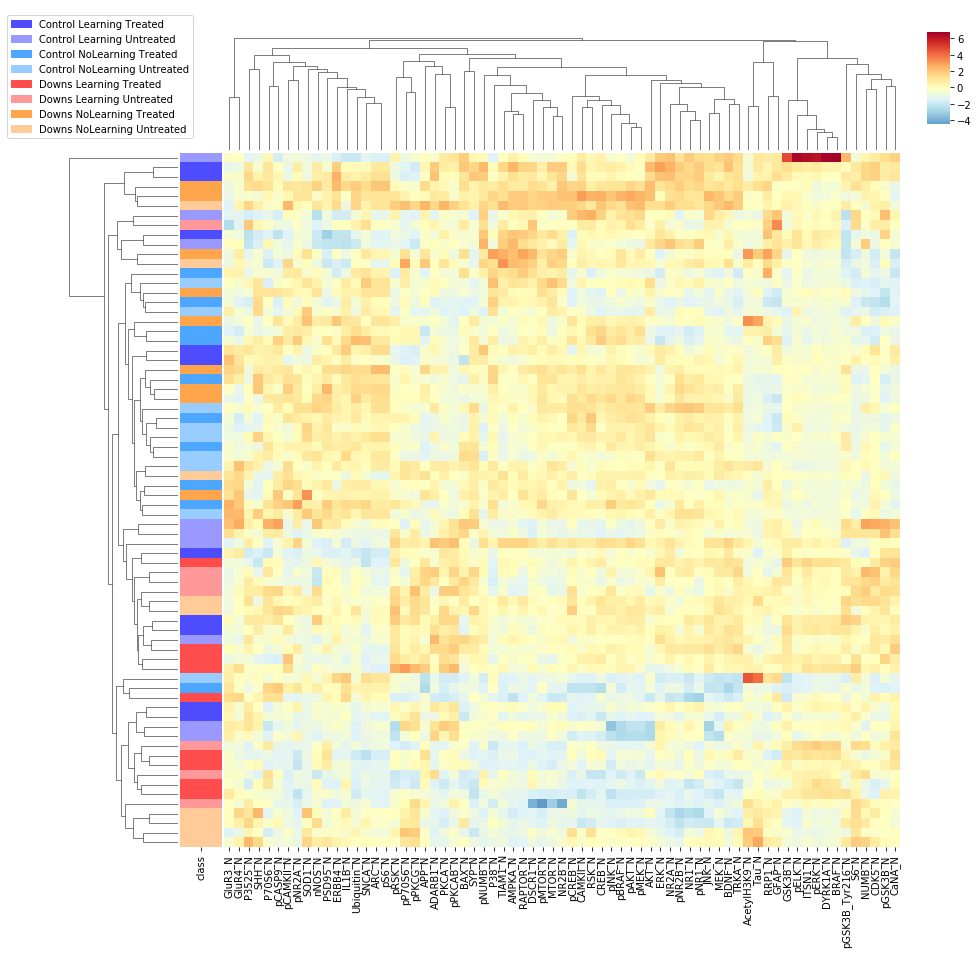

In [199]:
clustermap = sns.clustermap(data2,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=True,
                   yticklabels=False, figsize = (15,15))
add_legend_to_cluster(clustermap)

It looks like the control genotype / no learning conditions (light blues) clusters together even before filtering for genes differing between groups.

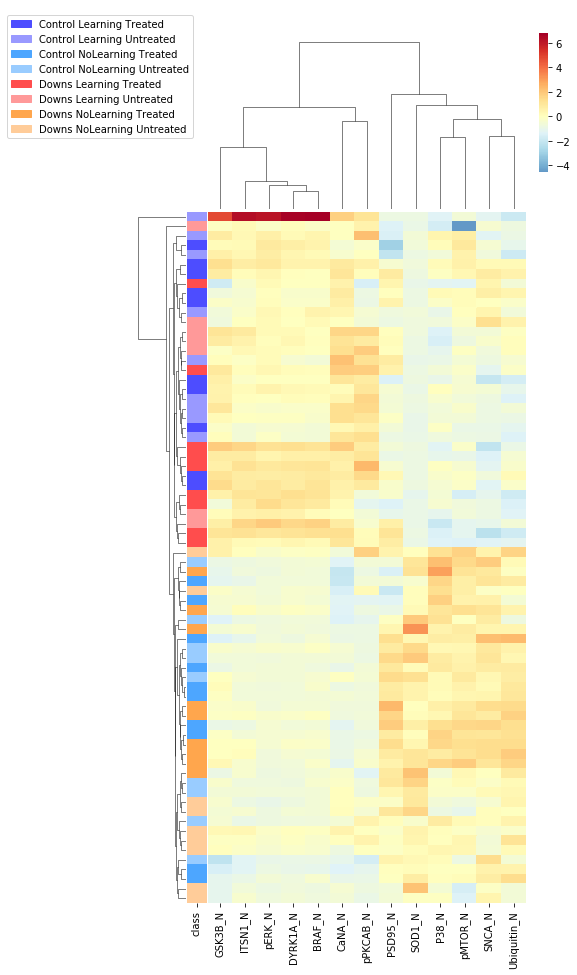

In [200]:
columns = ['DYRK1A_N', 'ITSN1_N', 'CaNA_N', 'SOD1_N', 'pERK_N', 'BRAF_N', 'GSK3B_N', 'pPKCAB_N', 'P38_N', 
           'pMTOR_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N']
cluster2=sns.clustermap(data2[columns],center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=True,
                   yticklabels=False,figsize=(7,16))
add_legend_to_cluster(cluster2)

When I restrict the proteins to those that appear to be regulated during learning, the learning conditions cluster away from the non-learning.

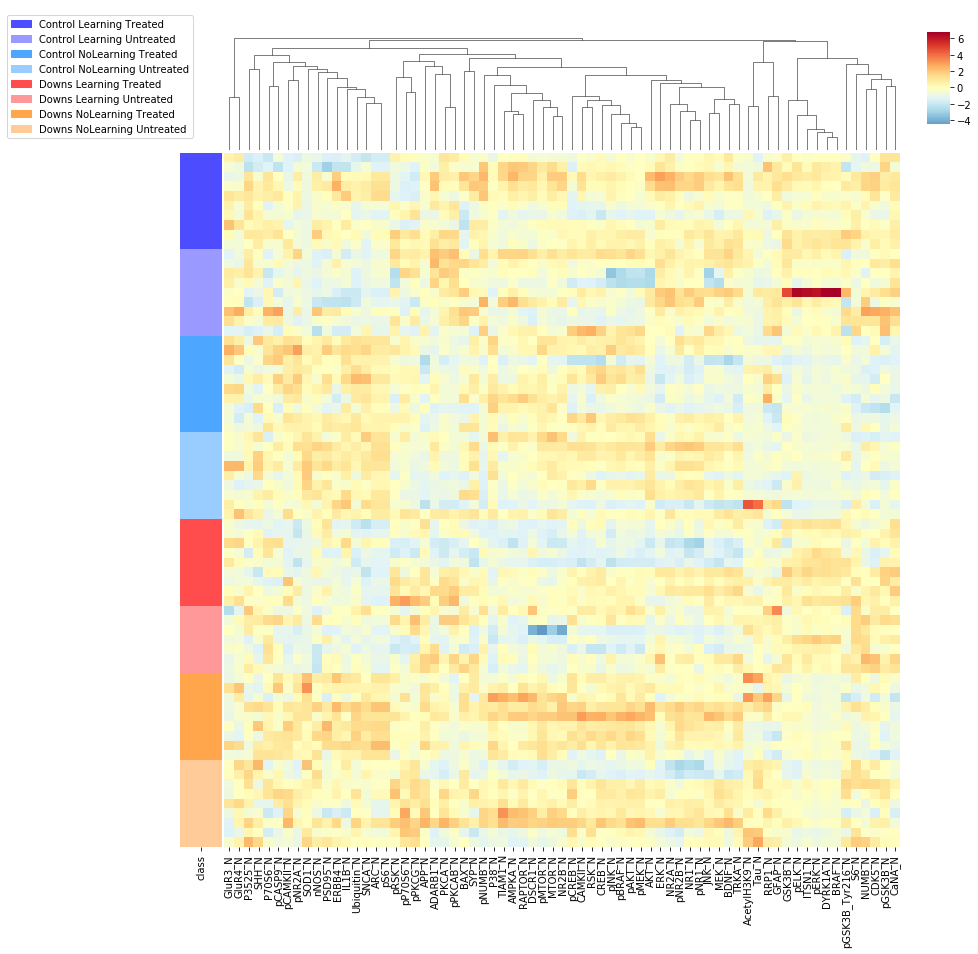

In [202]:
cluster3=sns.clustermap(data2,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=True,
                   yticklabels=False,figsize=(15,15),row_cluster=False)
add_legend_to_cluster(cluster3)

The nuclear levels of many proteins increase or decrease in the learning condition regardless of genotype or drug treatment.
    